In [1]:
using QuantumOptics
using Plots
using LaTeXStrings
using StatsBase
pyplot();

## Dynamics of Doppler cooling in a standing wave
A paradigmatic example for exploring the dynamics of cooling is to look at a two-level system in a standing wave. For the right detuning, it exhibits cooling up to the Doppler limit. We'll assume a standing wave of circularly polarized light that couples two levels. We'll take the semi-classical approach, which means we only treat the internal state of the atom quantum mechanically. I.e.:

$$
    \mathcal{H} = \cos\left(kz\right) \Omega \left( |e\rangle\langle g| + |g\rangle\langle e| \right) - \delta |e\rangle\langle e|.
$$

We'll discuss the (classical) motion below. First set the laser parameters:

In [2]:
δ = -0.5;
Ω = 0.5;
s₀ = 2 * Ω^2;
s = 2*Ω^2 / (4*δ^2 + 1);

Set up the two-level basis for operator definitions:

In [3]:
sbasis = GenericBasis(2);

Define the Hamiltonian and force as dense operators. (We could also use `SparseOperator()`, but who really cares about that in a two-level system?) The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [5]:
H(z) = DenseOperator(sbasis, Ω * [0 cos(z); cos(z) 0] - δ * [0 0; 0 1])
F(z) = DenseOperator(sbasis, Ω * [0 sin(z); sin(z) 0]);   # Force

Next define the quantum jump operators. There are two decay paths of equal strength. Recall that in our units the rate is simply 1:

In [6]:
rate = [1.];
L = [SparseOperator(sbasis, complex(sparse([0 1.; 0 0])))]
Ldagger = dagger.(L);

Define the initial condition and the time axis; these are the last ingredients needed for solving the master equation. We define a function that returns the force for some specified velocity:

In [7]:
function fquantum_master(t, ψ, u)
    return H(u[1]), L, Ldagger
end

fquantum_master (generic function with 1 method)

In [345]:
dimlessmass = 796.89;    # For Rb-87
dimlessmass = 200.       # For Na-23

pkicks = [1.; 1.; 1.; -1.; -1.; -1.; 0.; 0.; -2.; 2.];

function fclassical(t, ψ, u, du)
    # u[1] = z
    # u[2] = p
    du[1] = u[2]/dimlessmass;
    du[2] = real(expect(F(u[1]), ψ)) / (dagger(ψ) * ψ);
    return nothing
end

function fjump_classical(t, ψ, u, i)
    u[2] += sample(pkicks);
    u[3] += 1.;
    return nothing
end

fjump_classical (generic function with 1 method)

In [353]:
ψ₀ = Ket(sbasis, [1, 0]);
ψsc = semiclassical.State(ψ₀, ComplexF64[0., 0., 0.])
T = [0 : 0.01 : 4000;];

In [ ]:
Ntraj = 1000;
Ωs = [0.5];

ψsc0 = semiclassical.State(ψ₀, ComplexF64[0., 0., 0.]);

p_MCsq = [zeros(length(T)) for i in 1:length(Ωs)]
p_MC = [zeros(length(T)) for i in 1:length(Ωs)]
ρ = [];

for j = 1:length(Ωs)
    Ω = Ωs[j]
    for i = 1:Ntraj
        t_, ρ = semiclassical.mcwf_dynamic(T, ψsc0, fquantum_master, fclassical, fjump_classical); #; fout = fout);
        p_ = real.([ψ.classical[2] for ψ in ρ]);

        p_MC[j] += p_ / Ntraj;
        p_MCsq[j] += p_.^2 / Ntraj;
        if i % 10 == 0
            print(Ω, "\t", i, "\n");
        end
    end
    IJulia.clear_output()
end

0.5	10
0.5	20
0.5	30
0.5	40
0.5	50
0.5	60
0.5	70
0.5	80
0.5	90
0.5	100
0.5	110
0.5	120
0.5	130
0.5	140
0.5	150
0.5	160
0.5	170
0.5	180
0.5	190
0.5	200
0.5	210
0.5	220
0.5	230
0.5	240
0.5	250
0.5	260
0.5	270
0.5	280
0.5	290
0.5	300
0.5	310
0.5	320
0.5	330
0.5	340
0.5	350
0.5	360
0.5	370
0.5	380
0.5	390
0.5	400
0.5	410
0.5	420
0.5	430
0.5	440
0.5	450
0.5	460


In [356]:
expF = [real(expect(F(ψ.classical[1]), ψ)) for ψ in ρ];
pos = [real(ψ.classical[1]) for ψ in ρ];
nScat = [real(ψ.classical[3]) for ψ in ρ];

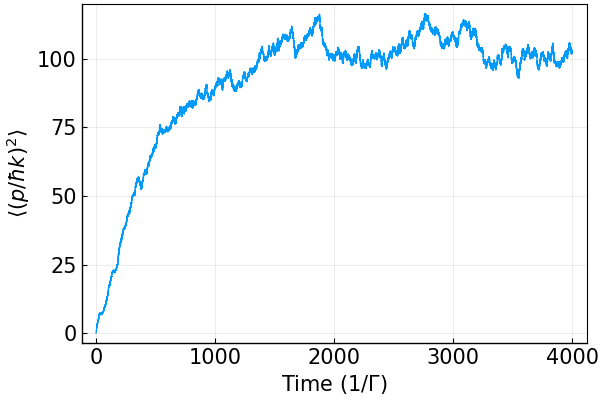

In [357]:
plot(T, p_MCsq[1], label = "",
    #xlim = (0, 20),
    #ylim = (0, 5),
    frame = true,
    xlabel = L"Time ($1/\Gamma$)",
    ylabel = L"$\langle \left(p/\hbar k \right)^2\rangle$",
    yaxis = font(15),
    xaxis = font(15))